In [184]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from datetime import date
from datetime import timedelta
import time
%matplotlib inline
from pathlib import Path 
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

In [185]:
#Find yesterday's date and convert it to string
today=date.today()
yesterday=today-timedelta(days=1)
ydate=yesterday.strftime("%d-%m-%Y")

#Specify Data folder
data_folder = Path("../data")

#Compute filename
data_file = ydate + ".csv"

#Compute complete filepath for the day
file_path = data_folder / data_file

#Read file to data frame
df=pd.read_csv(file_path)

df['Date']= pd.to_datetime(df['Date'], dayfirst=True)
df=df[df['Date']!=today] #Drop today's data
df_h=df[df['Status']=='Hospitalized']
df_r=df[df['Status']=='Recovered']
df_d=df[df['Status']=='Deceased']

C:\Users\joses\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


In [186]:
#Daily New Cases count in India
ind_daily=pd.DataFrame(df_h.groupby('Date')['Num_Cases'].sum())
ind_daily.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
#ind_daily.tail(10)

In [187]:
#Cumulative Cases in India
ind_cum=ind_daily.cumsum()
ind_cum.rename(columns={'Daily New Cases':'Cumulative Cases'},inplace=True)

In [188]:
#Specify Export folder 
export_folder =Path("../exports")
export_folder_path = export_folder / ydate

try:
    os.mkdir(export_folder_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")

#File Name for States Daily and file path
fnsd = "State Daily.csv"
fpsd = export_folder_path / fnsd

#File Name for States Cumulative and filepath 
fnsc = "State Cumulative.csv"
fpsc = export_folder_path / fnsc

Directory already exists


In [189]:
#Create a time series for States by New Cases
states=pd.DataFrame(df_h.groupby(['Date','State'])['Num_Cases'].sum())
states.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
state_daily=states.pivot_table(index='Date', columns='State', fill_value=0)
state_daily.to_csv(fpsd)

In [190]:
#Create a time series for States by Cumulative Cases 
state_cum=state_daily.cumsum()
state_cum.rename(columns={'Daily New Cases':'Cumulative Cases'}, inplace=True)
state_cum.tail()
state_cum.to_csv(fpsc)

In [191]:
#Arrange states in descending order of latest cumulative Cases
trans=state_cum.transpose()
sort_state=pd.DataFrame(trans[yesterday].sort_values(ascending=False))
mylist=sort_state.index.tolist() #Export to a list (Array of Cumulative Cases and State names)

In [192]:
state_list=[row[1] for row in mylist]#Creates a new list from the array above and extracts only the state names
#Split the States into three different categories according to their rank
top12=state_list[0:12] #Top 12 States
second12=state_list[12:24] #13-24 States
last=state_list[24:] #Last set of states

In [193]:
#Select Top 12 States by Cumulative Cases
top12cum=pd.DataFrame()
for i in range(12):
    top12cum[top12[i]]=state_cum['Cumulative Cases', top12[i]]

In [194]:
#Select the second 12 states by Cumulative Cases
second12cum=pd.DataFrame()
for i in range(12):
    second12cum[second12[i]]=state_cum['Cumulative Cases', second12[i]]

In [195]:
#Select Top 12 States by Daily New Cases
top12new=pd.DataFrame()
for i in range(12):
    top12new[top12[i]]=state_daily['Daily New Cases', top12[i]]

In [196]:
#Select the second 10 states by Daily New Cases
second12new=pd.DataFrame()
for i in range(12):
    second12new[second12[i]]=state_daily['Daily New Cases', second12[i]]

In [197]:
#Select the last set of states by Daily New Cases
lastnew=pd.DataFrame()
for i in range(len(last)):
    lastnew[last[i]]=state_daily['Daily New Cases', last[i]]

In [198]:
#Select the last set of states by Cumulative Cases
lastcum=pd.DataFrame()
for i in range(len(last)):
    lastcum[last[i]]=state_cum['Cumulative Cases', last[i]]

In [199]:
#Calculate the 7 day Rolling Average for Daily New Cases in india
ind_daily_7dra=pd.DataFrame()
ind_daily_7dra[ind_daily.columns[0]]=ind_daily.iloc[:,0].rolling(window=7).mean()

In [200]:
#Calculate 7-Day Rolling Average for Top 12 States
top12new7dra=pd.DataFrame()
for i in range(12):
    name=top12new.columns[i]
    top12new7dra[name]= top12new.iloc[:,i].rolling(window=7).mean()

In [201]:
top12new7dra2=pd.DataFrame()
for i in range(12):
    name=top12new7dra.columns[i]
    top12new7dra2[name]=top12new7dra.iloc[:,i]
top12new7dra2.reset_index(drop=True,inplace=True)

In [202]:
#Extract Data where average cases >10 (set range 8-15 to include all states)
top12new7dra_dat=pd.DataFrame()
for j in range(12):
    for i in range(60):
        if top12new7dra2.iloc[i,j] < 15.2:
            if top12new7dra2.iloc[i,j] > 8.0:
                name=top12new7dra2.columns[j]
                top12new7dra_dat[name]=top12new7dra2.iloc[i:,j]
                break
    continue
    
#Remove the date column and reset index
top12new7dra_dat.reset_index(drop=True,inplace=True)

#Remove NaN at top and align rows for different states
top12new7dra_dat2=pd.DataFrame()
for i in range(12):
    top12new7dra_dat[top12new7dra_dat.columns[i]].dropna(inplace=True)
    top12new7dra_dat[top12new7dra_dat.columns[i]].reset_index(drop=True,inplace=True)
    top12new7dra_dat2[top12new7dra_dat.columns[i]]=top12new7dra_dat[top12new7dra_dat.columns[i]]
    
#top12new7dra_dat2.head()

In [203]:
#Graph Starting date is 23rd April; Calculate number of days as integer
x=(today-date(2020,3,23)).days

In [204]:
chart_folder= Path("../charts")
export_path=chart_folder/ydate
try:
    os.mkdir(export_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")


Directory already exists


In [205]:
source="Source: www.covid19india.org"

In [206]:
yticks=[1, 5,10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

#  Top 13-24 States

In [207]:
#Calculate 7-Day Rolling Average for Top 13-24 States
second12new7dra=pd.DataFrame()
for i in range(12):
    name=second12new.columns[i]
    second12new7dra[name]= second12new.iloc[:,i].rolling(window=7).mean()

second12new7dra2=pd.DataFrame()
for i in range(12):
    name=second12new7dra.columns[i]
    second12new7dra2[name]=second12new7dra.iloc[:,i]
second12new7dra2.reset_index(drop=True,inplace=True)
    
#Extract Data where average cases >10 (set range 8-11 to include all states)
second12new7dra_dat=pd.DataFrame()
for j in range(12):
    for i in range(70):
        if second12new7dra2.iloc[i,j] < 11.0:
            if second12new7dra2.iloc[i,j] > 8.0:
                name=second12new7dra2.columns[j]
                second12new7dra_dat[name]=second12new7dra2.iloc[i:,j]
                break
    continue
    
#Remove the date column and reset index
second12new7dra_dat.reset_index(drop=True,inplace=True)

#Remove NaN at top and align rows for different states
second12new7dra_dat2=pd.DataFrame()

try:
    for i in range(12):
        second12new7dra_dat[second12new7dra_dat.columns[i]].dropna(inplace=True)
        second12new7dra_dat[second12new7dra_dat.columns[i]].reset_index(drop=True,inplace=True)
        second12new7dra_dat2[second12new7dra_dat.columns[i]]=second12new7dra_dat[second12new7dra_dat.columns[i]]
except:
    print("Done")

Done


#    Plots Start From Here

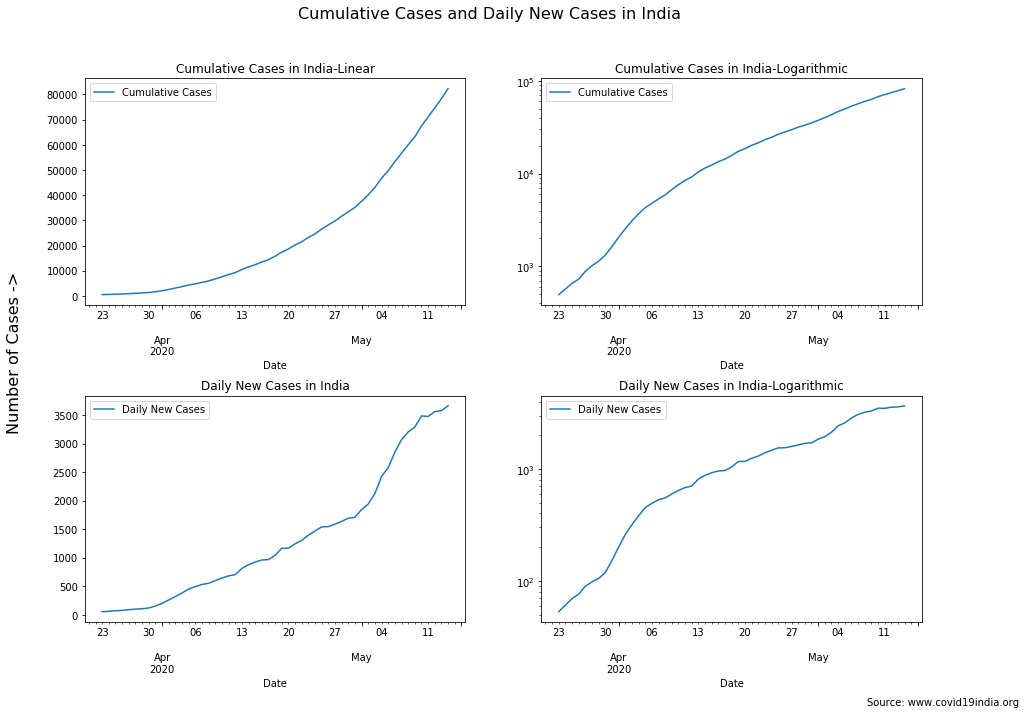

In [230]:
#Sub plots for India
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
figtit="Cumulative Cases and Daily New Cases in India"

ind_cum.tail(x).plot(kind='line', ax=axes[0,0], title='Cumulative Cases in India-Linear')
ind_cum.tail(x).plot(kind='line', ax=axes[0,1], title='Cumulative Cases in India-Logarithmic').set_yscale('log')
ind_daily_7dra.tail(x).plot(kind='line', ax=axes[1,0], title='Daily New Cases in India')
ind_daily_7dra.tail(x).plot(kind='line', ax=axes[1,1], title='Daily New Cases in India-Logarithmic').set_yscale('log')
fig.suptitle(figtit, fontsize=16)
plt.figtext(0.99, 0.01, source, horizontalalignment='right')
fig.text(0.06, 0.5, 'Number of Cases ->', ha='center', va='center', rotation='vertical', fontsize=16)


figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

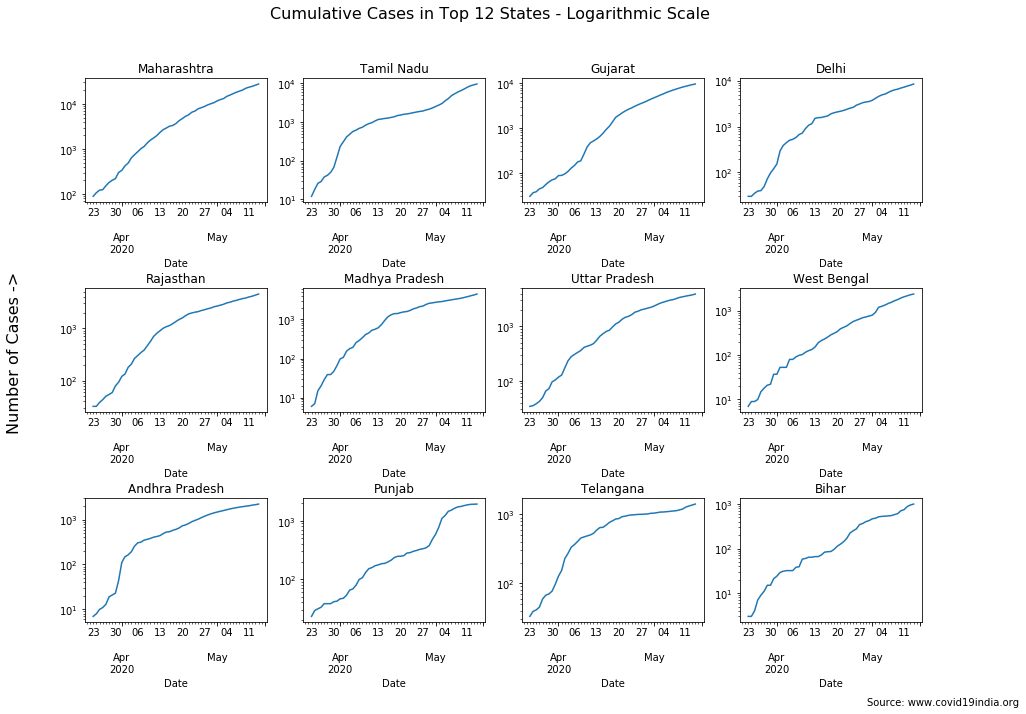

In [231]:
#Subplots for Top 12 States Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 12 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            top12cum[top12cum.columns[a]].tail(x).plot(kind='line', ax=axes[i,j], title=top12cum.columns[a]).set_yscale('log')
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
plt.figtext(0.99, 0.01, source, horizontalalignment='right')
fig.text(0.06, 0.5, 'Number of Cases ->', ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

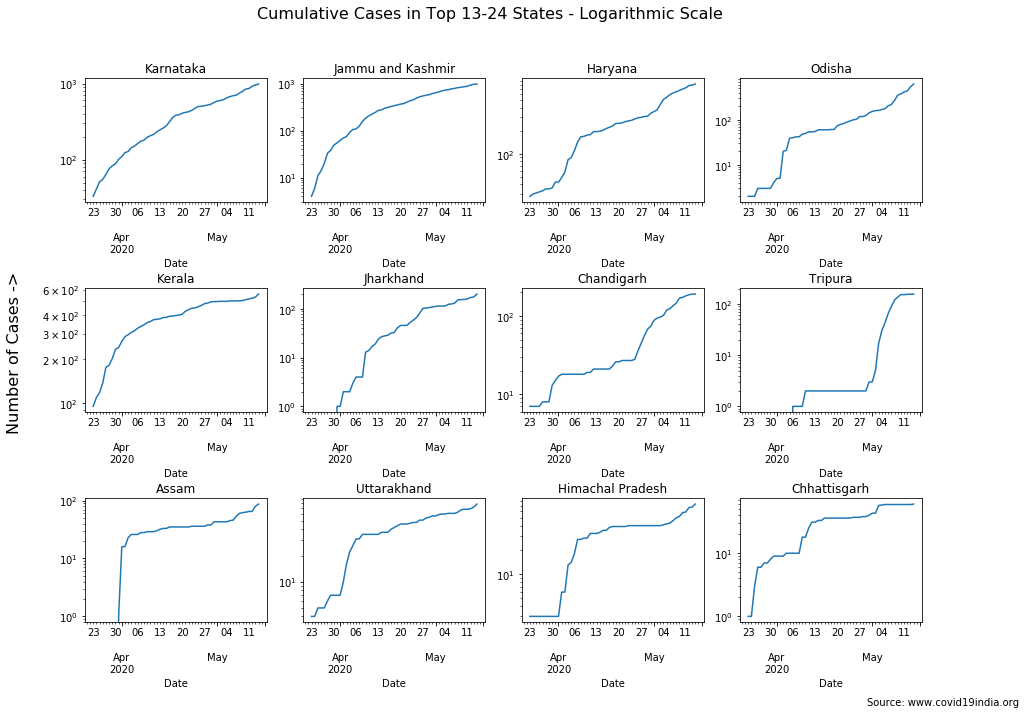

In [232]:
#Sub plots for top 13-24 States Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 13-24 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            second12cum[second12cum.columns[a]].tail(x).plot(kind='line', ax=axes[i,j], title=second12cum.columns[a]).set_yscale('log')
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
plt.figtext(0.99, 0.01, source, horizontalalignment='right')
fig.text(0.06, 0.5, 'Number of Cases ->', ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

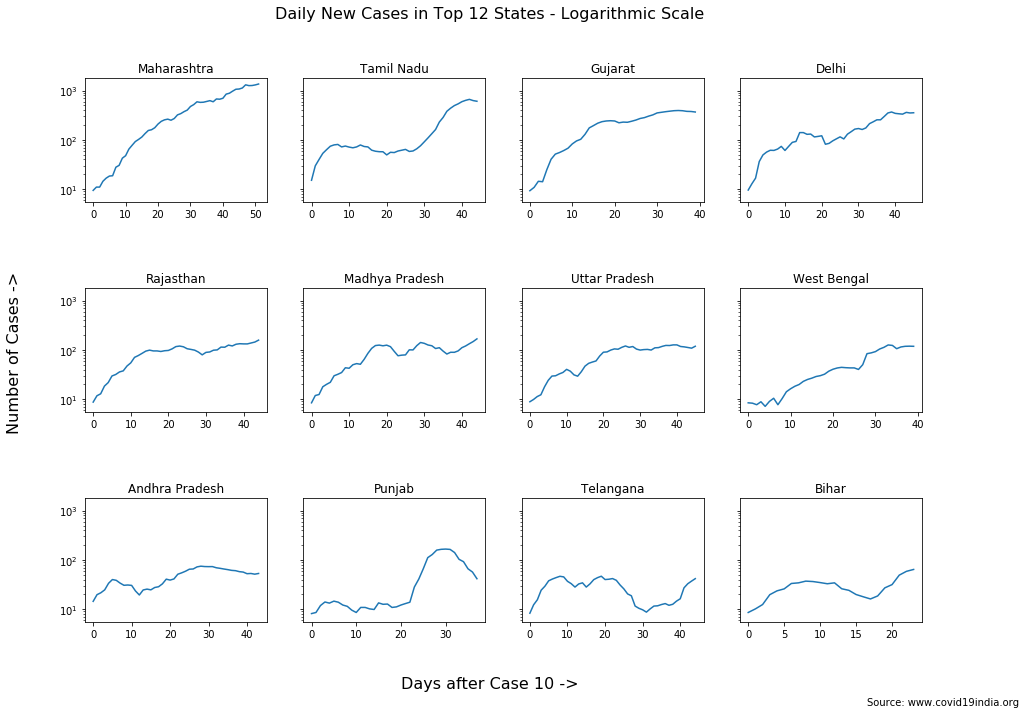

In [233]:
#Subplots for Daily New Cases - Top 12 States

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Daily New Cases in Top 12 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            top12new7dra_dat2[top12new7dra_dat2.columns[a]].tail(x).plot(kind='line', ax=axes[i,j] , title=top12new7dra_dat2.columns[a]).set_yscale('log')
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
plt.figtext(0.99, 0.01, source, horizontalalignment='right')
fig.text(0.5, 0.04, 'Days after Case 10 ->', ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, 'Number of Cases ->', ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

Done


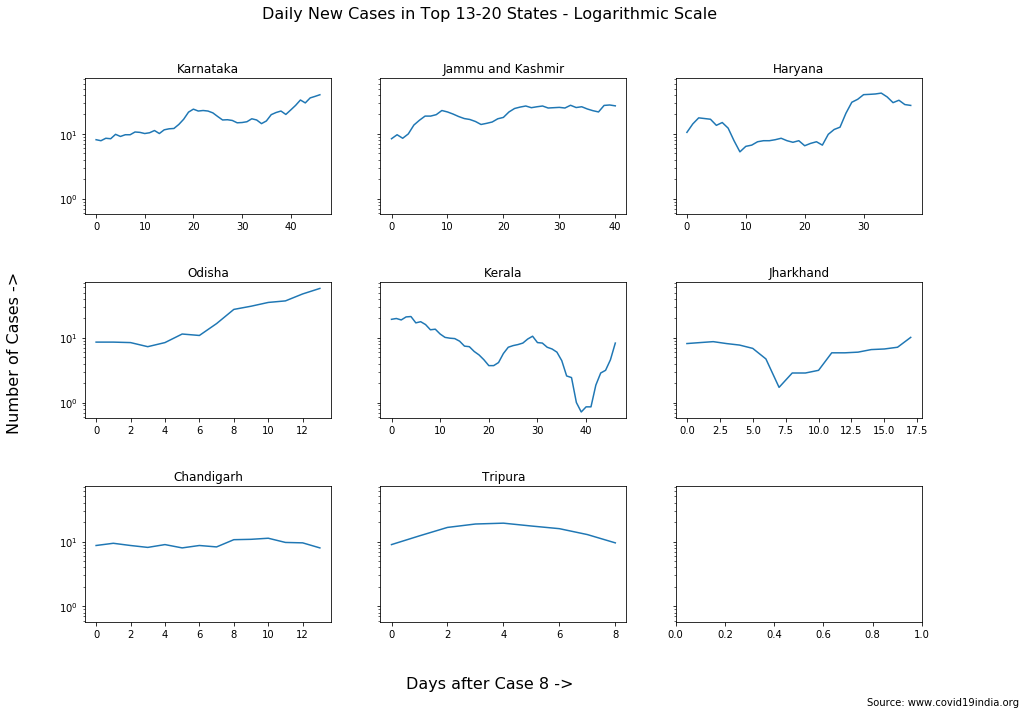

In [234]:
#Subplots for Daily New Cases - Top 13-24 States
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.5)
figtit="Daily New Cases in Top 13-20 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(3):
            a=(i*3)+j
            second12new7dra_dat2[second12new7dra_dat2.columns[a]].tail(x).plot(kind='line', ax=axes[i,j], title=second12new7dra_dat2.columns[a]).set_yscale('log')
            
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
plt.figtext(0.99, 0.01, source, horizontalalignment='right')
fig.text(0.5, 0.04, 'Days after Case 8 ->', ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, 'Number of Cases ->', ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()